In [1]:
import openfermionpyscf as ofpyscf
import openfermion as of
import cirq
import openfermioncirq as ofc
import numpy as np
import pyscf

In [2]:
from openfermion.transforms import get_fermion_operator, jordan_wigner, bravyi_kitaev
geometry = [["H", [0, 0, 0]],
            ["H", [0, 0, 0.7414]]]
basis = "sto-3g"
multiplicity = 1
charge = 0
hamiltonian = ofpyscf.generate_molecular_hamiltonian(geometry, basis, multiplicity, charge)
hamiltonian_jw = jordan_wigner(hamiltonian)
print(hamiltonian_jw)

-0.0988639693354571 [] +
-0.045322202052874 [X0 X1 Y2 Y3] +
0.045322202052874 [X0 Y1 Y2 X3] +
0.045322202052874 [Y0 X1 X2 Y3] +
-0.045322202052874 [Y0 Y1 X2 X3] +
0.17119774903432944 [Z0] +
0.16862219158920938 [Z0 Z1] +
0.120544822053018 [Z0 Z2] +
0.165867024105892 [Z0 Z3] +
0.17119774903432947 [Z1] +
0.165867024105892 [Z1 Z2] +
0.120544822053018 [Z1 Z3] +
-0.22278593040418496 [Z2] +
0.17434844185575687 [Z2 Z3] +
-0.22278593040418496 [Z3]


In [3]:
from openfermion.hamiltonians import MolecularData
molecule = MolecularData(geometry, basis, multiplicity, charge)
h2_molecule = ofpyscf.run_pyscf(molecule, run_mp2=True, run_cisd=True, run_ccsd=True, run_fci=True)
elektron=h2_molecule.n_electrons
orbitals = h2_molecule.n_orbitals
qubit= h2_molecule.n_qubits

In [4]:
from openfermion.utils import uccsd_singlet_generator
initial_amplitudes = np.linspace(0,0.05677,2)
#membuat ansatz UCCSD
uccsd_fermion=uccsd_singlet_generator(initial_amplitudes,qubit,elektron)
print(uccsd_fermion)

-0.05677 [0^ 2 1^ 3] +
-0.05677 [1^ 3 0^ 2] +
0.05677 [2^ 0 3^ 1] +
0.05677 [3^ 1 2^ 0]


In [5]:
# ansatz dirubah dari fermion operator menjadi qubit operator
uccsd_jw=jordan_wigner(uccsd_fermion)
print(uccsd_jw)

-0.0141925j [X0 X1 X2 Y3] +
-0.0141925j [X0 X1 Y2 X3] +
0.0141925j [X0 Y1 X2 X3] +
-0.0141925j [X0 Y1 Y2 Y3] +
0.0141925j [Y0 X1 X2 X3] +
-0.0141925j [Y0 X1 Y2 Y3] +
0.0141925j [Y0 Y1 X2 Y3] +
0.0141925j [Y0 Y1 Y2 X3]


In [6]:
class MyAnsatz(ofc.VariationalAnsatz):

    def params(self):
        """The parameters of the ansatz."""
        return [cirq.Symbol('theta_0')]

    def operations(self, qubits):
        """Produce the operations of the ansatz circuit."""
        q0, q1, q2, q3 = qubits
        yield cirq.H(q0), cirq.H(q1), cirq.H(q2)
        yield cirq.XPowGate(exponent=-0.5).on(q3)

        yield cirq.CNOT(q0, q1), cirq.CNOT(q1, q2), cirq.CNOT(q2, q3)
        yield cirq.ZPowGate(exponent=cirq.Symbol('theta_0')).on(q3)
        yield cirq.CNOT(q2, q3), cirq.CNOT(q1, q2), cirq.CNOT(q0, q1)

        yield cirq.H(q0), cirq.H(q1), cirq.H(q2)
        yield cirq.XPowGate(exponent=0.5).on(q3)

    def _generate_qubits(self):
        """Produce qubits that can be used by the ansatz circuit."""
        return cirq.LineQubit.range(4)

In [7]:
ansatz = MyAnsatz()
print(ansatz.circuit)

0: ───H────────@───────────────────────────────────@───H───
               │                                   │
1: ───H────────X───@───────────────────────@───────X───H───
                   │                       │
2: ───H────────────X───@───────────────@───X───────H───────
                       │               │
3: ───X^-0.5───────────X───Z^theta_0───X───X^0.5───────────


In [10]:

# Define the objective function
objective = ofc.HamiltonianObjective(hamiltonian_jw)

# Create preparation circuit
q0, q1, _, _ = ansatz.qubits
preparation_circuit = cirq.Circuit.from_ops(cirq.X(q0), cirq.X(q1))

# Create variational study
study = ofc.VariationalStudy(
    name='my_hydrogen_study',
    ansatz=ansatz,
    objective=objective,
    preparation_circuit=preparation_circuit)

print(study.circuit)

0: ───X───H────────@───────────────────────────────────@───H───
                   │                                   │
1: ───X───H────────X───@───────────────────────@───────X───H───
                       │                       │
2: ───────H────────────X───@───────────────@───X───────H───────
                           │               │
3: ───────X^-0.5───────────X───Z^theta_0───X───X^0.5───────────


In [11]:
# Choose an initial guess
initial_guess = [0.0]
print('Value of initial guess: {}'.format(study.value_of(initial_guess)))

# Choose an algorithm
algorithm = ofc.optimization.ScipyOptimizationAlgorithm(
    kwargs={'method': 'nelder-mead'},
    options={'maxiter': 100,'disp':True})

# Create OptimizationParams object
optimization_params = ofc.optimization.OptimizationParams(
    algorithm=algorithm,
    initial_guess=initial_guess)

# Run optimization
result = study.optimize(optimization_params)
print('Optimized value: {}'.format(result.optimal_value))
print(result.optimal_parameters)

Value of initial guess: -1.1166843870853402
Optimization terminated successfully.
         Current function value: -1.137270
         Iterations: 17
         Function evaluations: 34
Optimized value: -1.1372701732818402
[0.072]


In [12]:
import numpy as np
E=[]
thetas = np.linspace(-0.1,0.1,50)
for t in thetas:
    E.append(study.value_of([t]))
print(E)

[-1.022097196868859, -1.0273732045432302, -1.032534337322288, -1.0375797465989374, -1.0425086027936483, -1.0473200954908573, -1.0520134335722156, -1.0565878453466704, -1.061042578677345, -1.065376901105211, -1.0695900999695165, -1.0736814825249683, -1.0776503760556302, -1.081496127985538, -1.0852181059859929, -1.0888156980795336, -1.092288312740559, -1.0956353789925861, -1.0988563465021353, -1.101950685669214, -1.1049178877143966, -1.1077574647624797, -1.1104689499226996, -1.1130518973654977, -1.1155058823958288, -1.1178305015229868, -1.1200253725269502, -1.122090134521227, -1.1240244480121913, -1.1258279949549068, -1.1275004788054177, -1.1290416245695074, -1.1304511788479163, -1.1317289098780043, -1.1328746075718577, -1.133888083550832, -1.1347691711765295, -1.1355177255781927, -1.1361336236765287, -1.136616764203943, -1.136967067721195, -1.1371844766304524, -1.137268955184769, -1.1372204894939566, -1.137039087526873, -1.1367247791101087, -1.1362776159230847, -1.1356976714895541, -1.1

In [25]:
g=ofc.optimization.OptimizationAlgorithm(optimize)
g.function_values

NameError: name 'optimize' is not defined

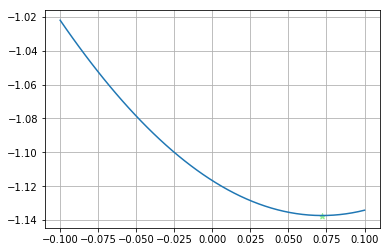

In [21]:
import matplotlib.pyplot as plt
plt.figure()
plt.grid
plt.plot(thetas,E)
plt.scatter(result.optimal_parameters,result.optimal_value,color='lightgreen',marker='*')

In [10]:
# Choose an initial guess
initial_guess = [0.0]
print('Value of initial guess: {}'.format(study.value_of(initial_guess)))

# Choose an algorithm
algorithm = ofc.optimization.ScipyOptimizationAlgorithm(
    kwargs={'method': 'SLSQP'},
    options={'maxiter': 100,'disp':True})

# Create OptimizationParams object
optimization_params = ofc.optimization.OptimizationParams(
    algorithm=algorithm,
    initial_guess=initial_guess)

# Run optimization
result = study.optimize(optimization_params)
print('Optimized value: {}'.format(result.optimal_value))

Value of initial guess: -1.1166843870853402
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1.1372701472322135
            Iterations: 3
            Function evaluations: 10
            Gradient evaluations: 3
Optimized value: -1.1372701472322135


In [11]:
# Choose an initial guess
initial_guess = [0.0]
print('Value of initial guess: {}'.format(study.value_of(initial_guess)))

# Choose an algorithm
algorithm = ofc.optimization.ScipyOptimizationAlgorithm(
    kwargs={'method': 'Powell'},
    options={'maxiter': 100,'disp':True})

# Create OptimizationParams object
optimization_params = ofc.optimization.OptimizationParams(
    algorithm=algorithm,
    initial_guess=initial_guess)

# Run optimization
result = study.optimize(optimization_params)
print('Optimized value: {}'.format(result.optimal_value))

Value of initial guess: -1.1166843870853402
Optimization terminated successfully.
         Current function value: -1.137270
         Iterations: 2
         Function evaluations: 24
Optimized value: -1.1372701746603915
